In [34]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
stratify = importr('SamplingStrata')

import resiliencyTool as rt
import pandas as pd
import numpy as np
import warnings
import math
import matplotlib.pyplot as plt

warnings.simplefilter("ignore") # warning are ignored for now

In [36]:
simulationName = 'strata_example'
network = rt.network.Network(simulationName)
simulation = rt.simulation.Sim(simulationName)

x_min = 0.722
x_max = 1.5
N = 10000
z = np.linspace(x_min,x_max,N)

network.return_period.update_return_period("return_period.csv")
n_clusters = 4

fc1 = network.fragilityCurves['p_f1']
fc2 = network.fragilityCurves['p_f2']

z, _ = network.return_period.stratify(x_min,x_max,N, fc1, n_clusters)

y1 = fc1.interpolate(z)
y2 = fc2.interpolate(z)

ids = list(range(len(z)))
domain = [1]*len(z)

df = pd.DataFrame(np.transpose(np.array([ids, y1, y2, z, domain])), columns=["id", "y1", "y2", "x", "domain"])
   
df

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

did not converge
did not converge
did not converge


 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

did not converge
did not converge
did not converge


 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

did not converge
did not converge
did not converge


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

did not converge
did not converge


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


start= 1, stop= 41
start= 12, stop= 17


,id,y1,y2,x,domain
0,0.0,0.000000,0.000000,0.546115,1.0
1,1.0,0.000000,0.000000,0.546129,1.0
2,2.0,0.000000,0.000000,0.546143,1.0
3,3.0,0.000000,0.000000,0.546158,1.0
4,4.0,0.000000,0.000000,0.546172,1.0
...,...,...,...,...,...
9995,9995.0,0.584021,0.614425,1.176511,1.0
9996,9996.0,0.584793,0.614887,1.177111,1.0
9997,9997.0,0.585568,0.615350,1.177712,1.0
9998,9998.0,0.586345,0.615813,1.178315,1.0


In [32]:
robjects.r('''
        mvarStratify <- function(df) {
            
                                        library(SamplingStrata)

                                        frame <- buildFrameDF(df = df,
                                                               id = "id",
                                                               X = c("x"),
                                                               Y = c("y1", "y2"),
                                                               domainvalue = "domain")

                                        cv <- as.data.frame(list(DOM=rep("DOM1",1),
                                                             CV1=rep(0.12,1),
                                                             CV2=rep(0.12,1),
                                                             domainvalue=c(1:1)))

                                        kmean <- KmeansSolution2(frame=frame,
                                                                     errors=cv,
                                                                     maxclusters = 10,
                                                                     showPlot = FALSE)

                                        nstrat <- tapply(kmean$suggestions,
                                                            kmean$domainvalue,
                                                            FUN=function(x) length(unique(x)))

                                        sugg <- prepareSuggestion(kmean=kmean,
                                                                    frame=frame,
                                                                    nstrat=nstrat)

                                        solution <- optimStrata(method = "continuous",
                                                                    errors = cv, 
                                                                    framesamp = frame,
                                                                    iter = 50,
                                                                    pops = 20,
                                                                    nStrata = nstrat,
                                                                    suggestions = sugg,
                                                                    showPlot = FALSE)


                                        strataStructure <- summaryStrata(solution$framenew,
                                                                             solution$aggr_strata,
                                                                             progress=FALSE)

                                        return(strataStructure)
                                    }
            ''')

mvarStratify_r = robjects.globalenv['mvarStratify']

out = mvarStratify_r(robjects.conversion.py2rpy(df))


Strata  3
Sample size  17
Strata  4
Sample size  10
-----------------
 Kmeans solution 
-----------------
 *** Domain:  1  ***
 Number of strata:  4
 Sample size     :  10
Computations are being done on population data

Number of strata:  4
... of which with only one unit:  0
Input data have been checked and are compliant with requirements

 *** Domain :  1   1
 Number of strata :  10000
 *** Sample cost:  9.904211
 *** Number of strata:  4
 *** Sample size :  10
 *** Number of strata :  4
---------------------------

(array([3532., 2284., 1480.,  952.,  623.,  373.,  264.,  207.,  162.,
         123.]),
 array([0.54611465, 0.60939512, 0.67267558, 0.73595605, 0.79923652,
        0.86251699, 0.92579745, 0.98907792, 1.05235839, 1.11563886,
        1.17891932]),
 <BarContainer object of 10 artists>)

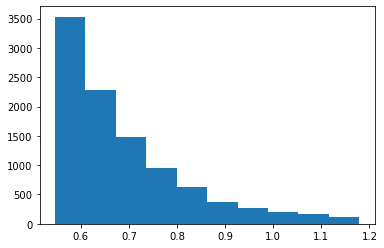

In [38]:
from rpy2.robjects import pandas2ri

base = importr('base')
pandas2ri.activate()

df_res = robjects.conversion.rpy2py(out)
df_res

plt.hist(z)